# Pulse Analysis

Getting the idea from [1] to use a error function (the integral of a gaussian) as the shape of pulse to evaluate the relation between its rise time (RT) and bandwidth (BW). The cumulative distribution function of a gaussian [2], $\Phi \left( \frac{x - \mu}{\sigma} \right)$, is defined as:

$\Phi \left( \frac{x - \mu}{\sigma} \right) = \frac{1}{2} \left[ 1 + erf\left( \frac{x - \mu}{\sigma \sqrt{2}} \right) \right]$

Where:

$erf\left( x \right) = \frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^{2}}dt$

Lets start checking the [erf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erf.html) and [erfinv](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfinv.html) functions provided by the SciPy library [3]. 

In [168]:
# importing some useful libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy import special
from scipy.fft import fft

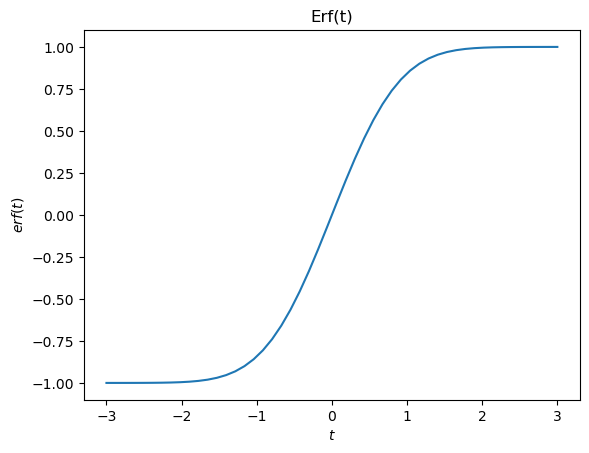

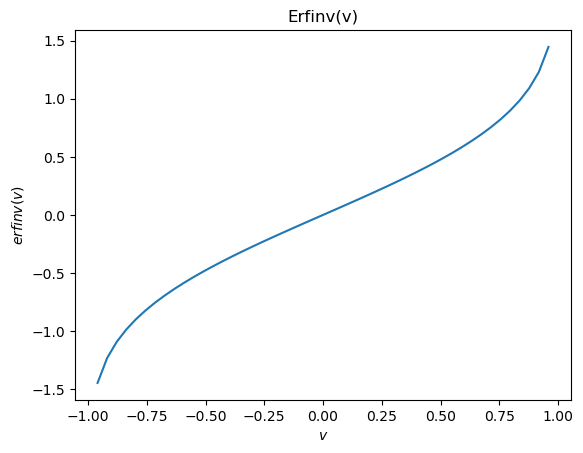

In [169]:
# visualizing the erf and erfinv
t = np.linspace(-3, 3)
plt.plot(t, special.erf(t))
plt.xlabel('$t$')
plt.ylabel('$erf(t)$')
plt.title('Erf(t)')
plt.show()

v = np.linspace(-1, 1)
plt.plot(v, special.erfinv(v))
plt.xlabel('$v$')
plt.ylabel('$erfinv(v)$')
plt.title('Erfinv(v)')
plt.show()

Now, lets define the [gaussian CDF](https://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution_function) (phi) to be the shape of our pulse and, its inverse (phiinv), also known as [quantile function](https://en.wikipedia.org/wiki/Normal_distribution#Quantile_function) as an auxiliary function, to calculate the rise time (10-90%) of our pulse. The pulse will be caracterized by its $\mu$ and $\sigma$, which will be tweaked to get the desired rise times.

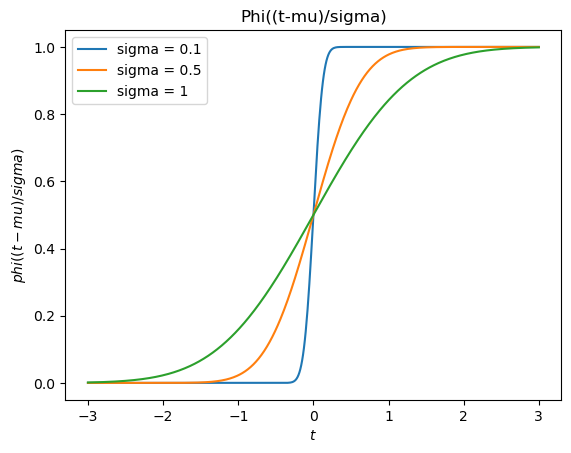

In [153]:
# using the erf to define the gaussian CDF
def phi(t, mu, sigma):
    return 1/2 * (1 + special.erf((t - mu)/(sigma * np.sqrt(2))))

t = np.linspace(-3, 3, num = 500)
mu = 0
sigma = 0.1
sigma2 = 0.5
sigma3 = 1

plt.plot(t, phi(t, mu, sigma), label = 'sigma = 0.1')
plt.plot(t, phi(t, mu, sigma2), label = 'sigma = 0.5')
plt.plot(t, phi(t, mu, sigma3), label = 'sigma = 1')

plt.xlabel('$t$')
plt.ylabel('$phi((t-mu)/sigma)$')
plt.title('Phi((t-mu)/sigma)')
plt.legend()
plt.show()

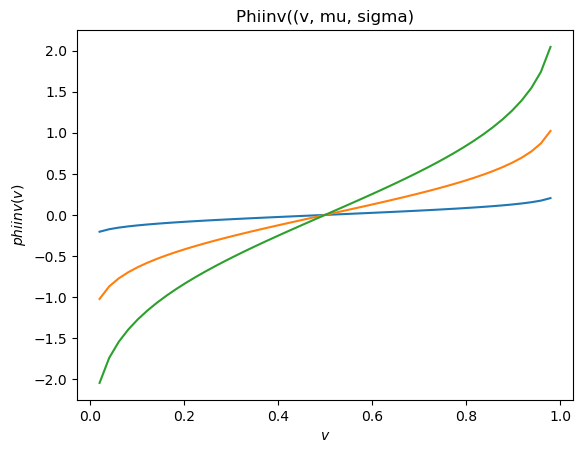

In [154]:
# using the erfinv to define the ineverse of the gaussian CDF

def phiinv(v, mu, sigma):
    return mu + sigma * (np.sqrt(2) * special.erfinv( 2 * v - 1))

v = np.linspace(0, 1)
mu = 0
sigma = 0.1
sigma2 = 0.5
sigma3 = 1

plt.plot(v, phiinv(v, mu, sigma), label = 'sigma = 0.1')
plt.plot(v, phiinv(v, mu, sigma2), label = 'sigma = 0.5')
plt.plot(v, phiinv(v, mu, sigma3), label = 'sigma = 1')

plt.xlabel('$v$')
plt.ylabel('$phiinv(v)$')
plt.title('Phiinv((v, mu, sigma)')
plt.show()

In [155]:
def risetime_10_90(mu, sigma):
    return phiinv(0.9, mu, sigma) - phiinv(0.1, mu, sigma)
    
risetime_10_90(mu, sigma)

0.2563103131089201

In [156]:
risetime_10_90(mu, sigma2)

1.2815515655446006

In [157]:
risetime_10_90(mu, sigma3)

2.563103131089201

So, lets define 3 pulses for this analysis with different rise times: 50ns, 100ns and 200ns.

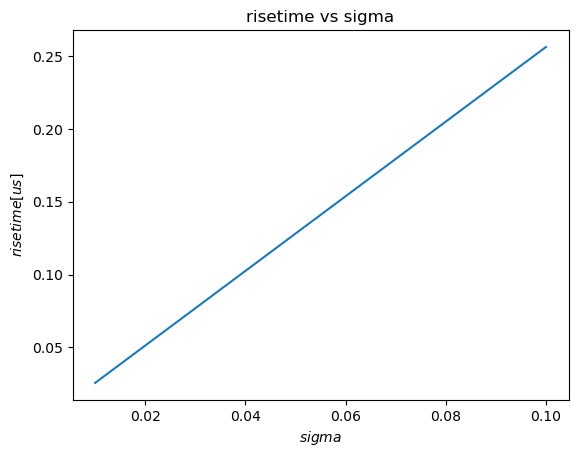

In [158]:
delta_sigma = np.linspace(0.01, 0.1, num = 5)

plt.plot(delta_sigma, risetime_10_90(0, delta_sigma), label = 'sigma = 1')

plt.xlabel('$sigma$')
plt.ylabel('$risetime [us]$')
plt.title('risetime vs sigma')
#plt.grid(visible = None, which = 'major', axis = 'y')
#plt.yticks(np.arange(0, 0.3, step=0.01))
plt.show()

In [159]:
risetime_10_90(0, 0.01951) #by inspection, RT=50ns can be obtained from sigma=0.01951

0.05000614208755031

In [160]:
risetime_10_90(0, 0.039016) #by inspection, RT=100ns can be obtained from sigma=0.039016

0.10000203176257629

In [161]:
risetime_10_90(0, 0.078032) #by inspection, RT=200ns can be obtained from sigma=0.078032

0.20000406352515257

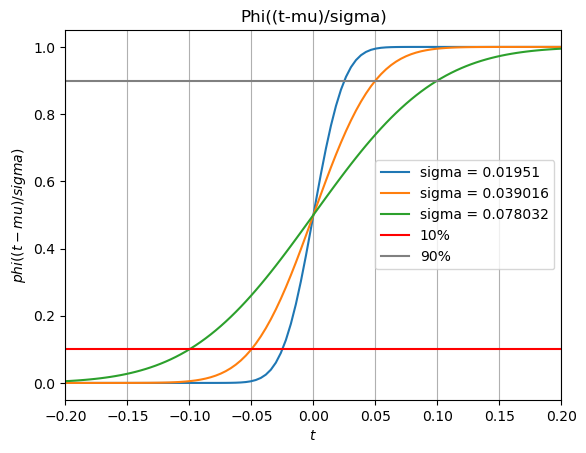

In [162]:
t = np.linspace(-0.2, 0.2, num = 100)
mu = 0
sigma = 0.01951
sigma2 = 0.039016
sigma3 = 0.078032

plt.plot(t, phi(t, mu, sigma), label = 'sigma = 0.01951')
plt.plot(t, phi(t, mu, sigma2), label = 'sigma = 0.039016')
plt.plot(t, phi(t, mu, sigma3), label = 'sigma = 0.078032')

plt.axhline(0.1, 0, 1, color = 'red', label = '10%')
plt.axhline(0.9, 0, 1, color = 'gray', label = '90%')

plt.grid(visible = True, which = 'both', axis='x')
plt.xlim(-0.2, 0.2)
plt.xlabel('$t$')
plt.ylabel('$phi((t-mu)/sigma)$')
plt.title('Phi((t-mu)/sigma)')
plt.legend()
plt.show()

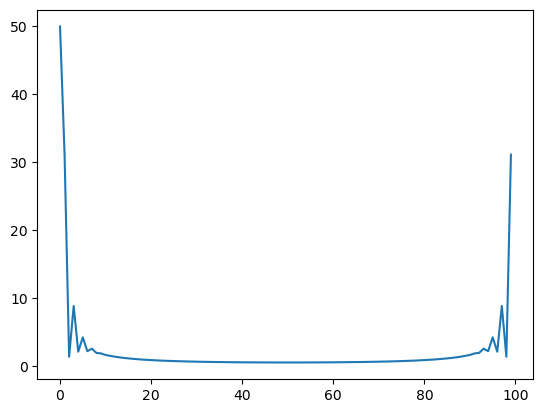

In [163]:
plt.plot(np.abs(fft(phi(t, mu, sigma))))
plt.show()

<a id='ref_1'></a>
[1] Bandwidth of Signals: What is Important, Rise Time or Slew Rate? - https://www.signalintegrityjournal.com/articles/2092-bandwidth-of-signals-what-is-important-rise-time-or-slew-rate?page=2

<a id='ref_2'></a>
[2] Normal distribution - https://en.wikipedia.org/wiki/Normal_distribution

<a id='ref_3'></a>
[3] SciPy documentation - https://docs.scipy.org/doc/scipy/index.html